In [1]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
# import sys
# sys.path.append('/content/gdrive/MyDrive/NN LABS')

Mounted at /content/gdrive


In [2]:
# Import the relevant Packages
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils import data
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

import time

# 1. Read the Dataset and Create Dataloaders

In [3]:
#Load the train and test datasets
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 29588266.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


1.1 Dataset Exploration

In [4]:
class_names = cifar_trainset.classes
class_num = len(class_names)

print("Number of images in the training set = ", len(cifar_trainset))
print("Number of images in the test set = ", len(cifar_testset))
print("Number of classes = ", class_num)
print("Classes names are = ", ", ".join(class_names))


Number of images in the training set =  50000
Number of images in the test set =  10000
Number of classes =  10
Classes names are =  airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck


Here we visualise a sample of 10 images.

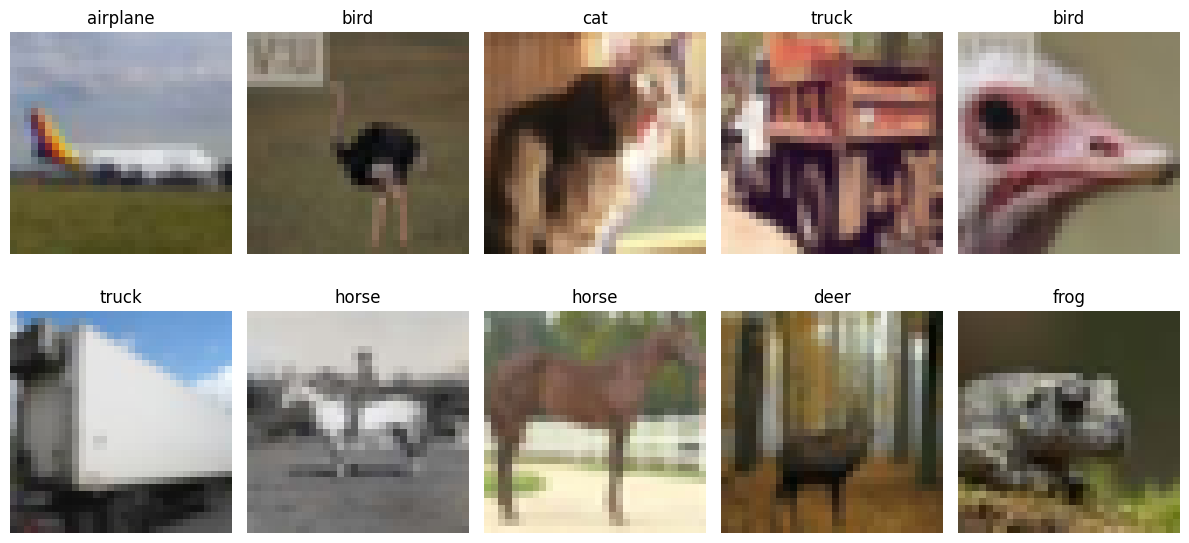

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(len(cifar_trainset))
        img, label = cifar_trainset[idx]
        ax[i, j].imshow(img)
        ax[i, j].set_title(class_names[label]) # Annotate the Sample Images with the appropriate labels
        ax[i, j].axis('off')

plt.tight_layout()
plt.show()

1.2 Transform Datasets and Create Dataloaders

We transform the datasets before we input it into the dataloaders. The transforms are decribed below:

**transforms.ToTensor():** This transform converts the input image to a PyTorch tensor. It also scales the pixel values from [0, 255] to [0, 1].

**transforms.RandomRotation(10):** This transform randomly rotates the input image by up to 10 degrees.

**transforms.RandomHorizontalFlip(0.5):**  this transform randomly flips the input image horizontally with a probability of 0.5.

**transforms.RandomCrop(32, padding=2):** This transform randomly crops the input image to size 32x32 with an additional padding of 2 pixels on each side.

**transforms.Normalize(cifar_mean, cifar_std):  **This transform normalizes the tensor image with mean and standard deviation values calculated from the CIFAR-10 dataset. The normalization is applied channel-wise, where each channel is normalized independently.

Note that we only use transforms.ToTensor() and transforms.Normalize(cifar_mean, cifar_std) for the train dataset as this could lead to incorrect evaluations of the model's performance. 

In [6]:
# we get the mean and std of the RGB channels of the images.
# these value will be used to normalise the tensor images
cifar_mean = np.mean(cifar_trainset.data, axis=(0, 1, 2)) / 255
cifar_std = np.std(cifar_trainset.data, axis=(0, 1, 2)) / 255

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32, padding = 2),
    transforms.Normalize(cifar_mean, cifar_std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

cifar_trainset.transform = train_transform
cifar_testset.transform = test_transform


create loaders

In [7]:
batch_size= 64
train_iter = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_iter = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False, num_workers=2)

# We get the dimensions of the X and y
X,y = next(iter(train_iter))
print("Dimensions of X: ",X.size())
print("Dimensions of y: ",y.size())

Dimensions of X:  torch.Size([64, 3, 32, 32])
Dimensions of y:  torch.Size([64])


* Here X is a pytorch tensor of dimension 64 x 3 x 32 x 32:
    - **64** here represents our batch size
    - **3** is the number of channels
    - **32 x 32** represents shape of an image with height *h* and width *w* pixels as *h* x *w* of each input image<br><br>
    
* y is a pytorch tensor aswell and represents the true label of the image represented by the tensor X

# 2. Model


Below I create my model. It is made up of a backbone and a classifier.

2.1 Backbone

The backbone structure of the model consists of 5 blocks. Each block comprises a fully connected layer that calculates the channel-wise weights, a set of 3 convolutional layers, and a batch normalisation layer. The adaptive convolutions are performed using the calculated channel-wise weights. The blocks take as input the output from the previous block, or the input image in the case of the first block, and output feature maps of increasing size.

2.2 Classifier

The classifier consists of a max pooling layer, a dropout layer, an adaptive average pooling layer, and a linear layer. The max pooling layer reduces the spatial dimensions of the feature maps by a factor of 2. The dropout layer is used to prevent overfitting. The adaptive average pooling layer reduces the feature maps to a 1x1 size, and the linear layer maps them to the output classes.

The ouputs of each layer:

1. After block 1: (32, 32, 32) - Block with 32 output channels and preserved spatial dimensions due to padding.

2. After maxpool (first): (32, 16, 16) - Max-pooling layer reduces spatial dimensions by 2.

3. After block 2: (64, 16, 16) - Block with 64 output channels and preserved spatial dimensions due to padding.

4. After max pool (second): (64, 8, 8) - Max-pooling layer reduces spatial dimensions by 2.

5. After dropout: (64, 8, 8) - The dropout layer does not change dimensions.

6. After block 3: (128, 8, 8) - Block with 128 output channels and preserved spatial dimensions due to padding.

7. After maxpool (third): (128, 4, 4) - Max-pooling layer reduces spatial dimensions by 2.

8. After block 4: (256, 4, 4) - Block with 256 output channels and preserved spatial dimensions due to padding.

9. After maxpool (fourth): (256, 2, 2) - Max-pooling layer reduces spatial dimensions by 2.

10. After block 5: (512, 2, 2) - Block with 512 output channels and preserved spatial dimensions due to padding.

11. After dropout: (512, 2, 2) - The dropout layer does not change dimensions.

12. After avgpool: (512, 1, 1) - Adaptive average pooling reduces the spatial dimensions to (1, 1).



In [8]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, k=3):
        super(Block, self).__init__()

        self.lin = nn.Linear(in_channels, k)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.convs = nn.ModuleList()
        for i in range(k):
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            nn.init.kaiming_normal_(conv.weight, mode='fan_in', nonlinearity='relu')
            self.convs.append(conv)

        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        # Calculate the channel-wise weights using the fully connected layer
        a = self.lin(self.pool(x).view(b, c))
        a = F.softmax(a, dim=1).view(b, -1, 1, 1)

        # Perform the adaptive convolutions with the calculated weights
        o = 0
        for i, conv in enumerate(self.convs):
            o += a[:, i:i + 1] * conv(x)

        o = self.bn(o)
        return o

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.block1 = Block(in_channels=3, out_channels=32)
        self.block2 = Block(in_channels=32, out_channels=64)
        self.block3 = Block(in_channels=64, out_channels=128)
        self.block4 = Block(in_channels=128, out_channels=256)
        self.block5 = Block(in_channels=256, out_channels=512)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.block1(x))
        x = self.maxpool(x)
        x = F.relu(self.block2(x))
        x = self.maxpool(x)
        x = self.dropout(x)
        x = F.relu(self.block3(x))
        x = self.maxpool(x)
        x = F.relu(self.block4(x))
        x = self.maxpool(x)
        x = F.relu(self.block5(x))
        x = self.dropout(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [45]:
# Instantiate the Model and enable CPU
model = Net() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model= model.to(device)

# 3. Create loss and Optimizer

In [46]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00025)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.000001)


# 4. Training Script and Model Training

In [40]:
def train_epoch(model, dataloader, criterion, optimizer, device, accumulation_steps=4):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    optimizer.zero_grad()  # Reset gradients on each loop
  
    # Loop through the training data (images and labels)
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)  
        outputs = model(images) 
        loss = criterion(outputs, labels)  # Calculate the loss
        loss /= accumulation_steps
        loss.backward()  # backpropagation to compute gradients

        # Optimisation: Update parameters on each minibatch
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()  
            optimizer.zero_grad()  # Reset gradients

        running_loss += loss.item() * accumulation_steps  # Accumulate the loss
        _, predicted = outputs.max(1) # Predicted Class labels
        total += labels.size(0)  
        correct += predicted.eq(labels).sum().item()  # total correct predictions

    # Update model parameters after accumulating gradients for the last mini-batch
    if i % accumulation_steps != accumulation_steps - 1:
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_loss / len(dataloader.dataset)  # average loss for the epoch
    epoch_acc = correct / len(dataloader.dataset)  #  accuracy for the epoch

    return epoch_loss, epoch_acc

In [41]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device) 

        with torch.no_grad():  # Disable gradient calculation as not needed to evaluate model
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  # Calculate loss

        running_loss += loss.item()  # Accumulate the loss

        _, predicted = torch.max(outputs, dim=1)  # Class labels
        total += labels.size(0)  
        correct += (predicted == labels).sum().item()  # Sum of correct predictions

    epoch_loss = running_loss / len(dataloader)  #  average loss for the epoch
    epoch_acc = correct / total  #  accuracy for the epoch

    return epoch_loss, epoch_acc

In [44]:
num_epochs = 50
print_every = 5

# Store the loss and accuracy history
train_loss_h = []
val_loss_h = []
train_acc_h = []
val_acc_h = []

start = time.time()
end = time.time()

# Loop through each epoch
for epoch in range(num_epochs):
    # Train the model for one epoch and calculate training loss and accuracy
    train_loss, train_acc = train_epoch(model, train_iter, criterion, optimizer, device)
    # Validate the model and calculate validation loss and accuracy
    val_loss, val_acc = validate_epoch(model, test_iter, criterion, device)

    # Update the learning rate scheduler at every epoch
    scheduler.step()

    # Store the calculated losses and accuracies for the current epoch
    train_loss_h.append(train_loss)
    val_loss_h.append(val_loss)
    train_acc_h.append(train_acc)
    val_acc_h.append(val_acc)

    # Print the losses and accuracies for the current epoch if it's a multiple of 'print_every'
    if (epoch + 1) % print_every == 0:
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, train_acc * 100, val_loss, val_acc* 100))


print(f'Training finished in {(end - start):.2f} seconds.')


Epoch [5/50], Train Loss: 0.0054, Train Acc: 87.8360, Val Loss: 0.4855, Val Acc: 84.2300
Epoch [10/50], Train Loss: 0.0053, Train Acc: 88.0240, Val Loss: 0.4883, Val Acc: 84.2600
Epoch [15/50], Train Loss: 0.0053, Train Acc: 87.9100, Val Loss: 0.5066, Val Acc: 83.8200
Epoch [20/50], Train Loss: 0.0054, Train Acc: 87.7960, Val Loss: 0.4956, Val Acc: 83.7800
Epoch [25/50], Train Loss: 0.0055, Train Acc: 87.5880, Val Loss: 0.4988, Val Acc: 83.8300
Epoch [30/50], Train Loss: 0.0053, Train Acc: 87.7700, Val Loss: 0.4919, Val Acc: 84.1600
Epoch [35/50], Train Loss: 0.0054, Train Acc: 87.7020, Val Loss: 0.5098, Val Acc: 83.9500
Epoch [40/50], Train Loss: 0.0053, Train Acc: 87.9980, Val Loss: 0.5049, Val Acc: 83.7800
Epoch [45/50], Train Loss: 0.0050, Train Acc: 88.4400, Val Loss: 0.4858, Val Acc: 84.5500
Epoch [50/50], Train Loss: 0.0049, Train Acc: 88.7540, Val Loss: 0.5041, Val Acc: 84.0600
Training finished in 0.00 seconds.


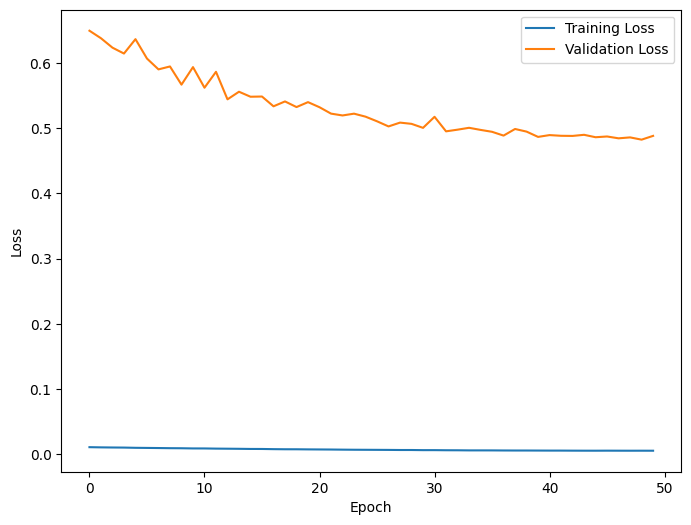

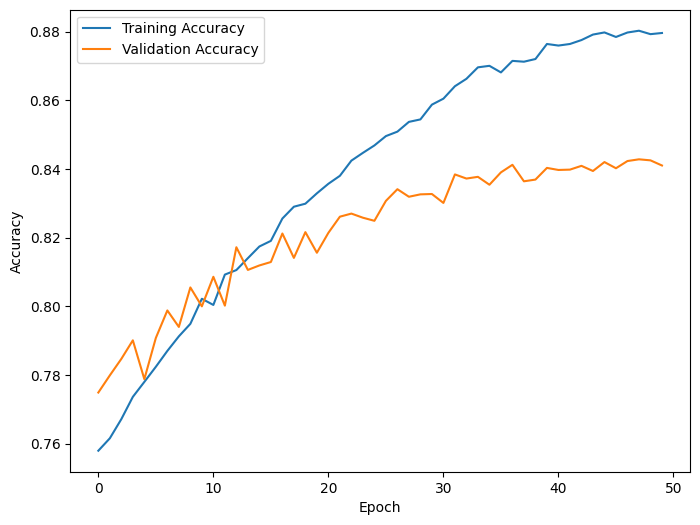

In [43]:
import matplotlib.pyplot as plt

# Plot the evolution of loss for training and validation
plt.figure(figsize=(8, 6))
plt.plot(train_loss_h, label='Training Loss')
plt.plot(val_loss_h, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the evolution of accuracy for training and validation
plt.figure(figsize=(8, 6))
plt.plot(train_acc_h, label='Training Accuracy')
plt.plot(val_acc_h, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()